In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

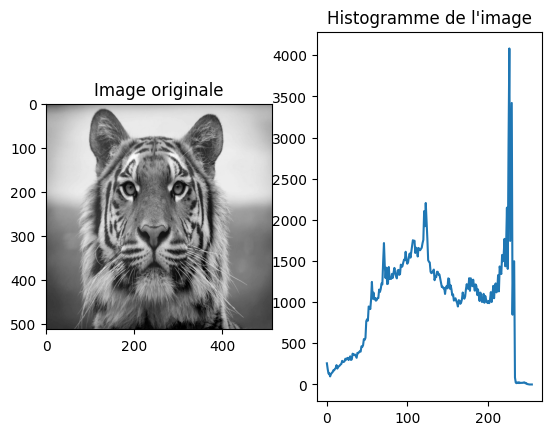

In [20]:
# lecture de l'image et conversion en niveaux de gris
img = cv2.imread('08.png', cv2.IMREAD_GRAYSCALE)
hist_img, bin_edges_img = np.histogram(img,bins=256,range=(0,256))

################# affichage #################
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Image originale')
plt.subplot(122)
plt.plot(hist_img)
plt.title('Histogramme de l\'image')
plt.show()

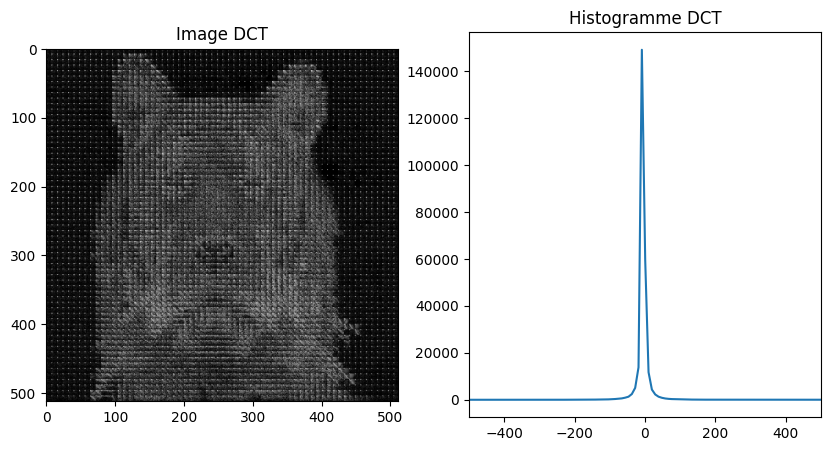

In [21]:
# division de l'image en imagettes 8x8 pixels
n = 8
h, w = img.shape
blocs = [img[j:j+n, i:i+n] for j in range(0,h,n) for i in range(0,w,n)] # liste des imagettes

# calcul de la DCT de chaque imagette
T_blocs = [cv2.dct(np.float32(bloc)) for bloc in blocs] # liste des DCT

# reconstruction de l'image à partir des DCT
T = np.zeros((h, w), np.float32)
for i, bloc in enumerate(T_blocs):
    x = (i * 8) % w
    y = (i * 8) // w * 8
    T[y:y+8, x:x+8] = bloc

T_log = np.log1p(np.abs(T))

hist_dct, bin_edges_dct = np.histogram(T,bins=256)

################## affichage ##################
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(T_log, cmap='gray')
plt.title('Image DCT')
plt.subplot(122)
plt.plot(bin_edges_dct[0:-1],hist_dct)
plt.xlim([-500,500])
plt.title('Histogramme DCT')
plt.show()

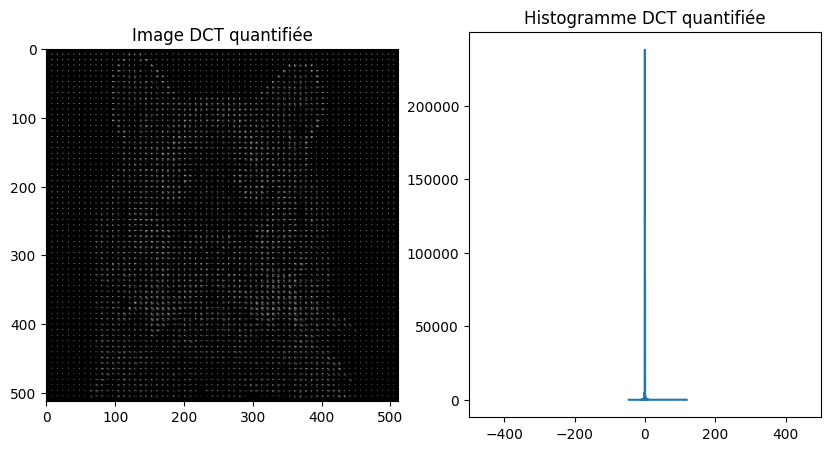

In [22]:
# matrice de quantification JPEG

Z = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# DCT tronquée/quantifiée

x,y = T.shape

T_chap_blocs = [np.fix(bloc/Z) for bloc in T_blocs]

T_chap = np.zeros((h, w), np.float32)

for i, bloc in enumerate(T_chap_blocs):
    x = (i * 8) % w
    y = (i * 8) // w * 8
    T_chap[y:y+8, x:x+8] = bloc

T_chap_log = np.log1p(np.abs(T_chap))
hist_T_chap, bin_edges_T_chap = np.histogram(T_chap,bins=256)

############### affichage #################
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(T_chap_log, cmap='gray')
plt.title('Image DCT quantifiée')
plt.subplot(122)
plt.plot(bin_edges_T_chap[0:-1],hist_T_chap)
plt.xlim([-500,500])
plt.title('Histogramme DCT quantifiée')
plt.show()

In [23]:
# encodage JPEG

def zigzag_order(matrix):
    # Retourne un tableau 1D contenant les éléments de la matrice en ordre zigzag

    rows, col = matrix.shape
    result = []

    for Sxy in range(col):                   # on parcourt les premières diagonales de la matrice
        if Sxy % 2 != 0:                     # si la diagonale est impaire
            for i in range(Sxy + 1):         # on boucle de 0 au numéro de la diagonale (i augmente)
                j = Sxy - i                  # j diminue pour suivre la diagonale
                result.append(matrix[i][j])  # on ajoute l'élément à la liste
        else:                                # si la diagonale est paire
            for j in range(Sxy + 1):         # on boucle j sur le numéro de la diagonale (j augmente)
                i = Sxy - j                  # i diminue pour suivre la diagonale
                result.append(matrix[i][j])

    for Sxy in range(col, rows):              # on parcourt les diagonales suivantes
        if Sxy % 2 != 0:
            for i in range(Sxy - col-1, col): # on boucle de la diagonale au nombre total de diagonales 
                j = Sxy - i
                result.append(matrix[i][j])
        else:
            for j in range(Sxy - col-1, col):
                i = Sxy - j
                result.append(matrix[i][j])
    return np.array(result)

T_pos_blocs = [(bloc != 0).astype(int) for bloc in T_chap_blocs]    # liste des matrices de positions (1 si != 0, 0 sinon)
T_pos_zigzag_blocs = [zigzag_order(bloc) for bloc in T_pos_blocs]   # liste des matrices de position en zigzag
T_val_zigzag_blocs = [zigzag_order(bloc) for bloc in T_chap_blocs]  # liste des matrices de valeurs en zigzag
T_val_blocs = [bloc[bloc != 0] for bloc in T_val_zigzag_blocs]      # liste des matrices de valeurs non nulles


In [24]:
def min_bits_to_code(values):
    """
    Retourne le nombre de bits minimum nécessaires pour coder tous les nombres dans la liste,
    en tenant compte des nombres négatifs et positifs.
    """

    # Convertir les valeurs en entiers Python pour pouvoir utiliser bit_length()
    int_values = map(int, values)
    # Trouver la valeur absolue maximale
    max_value = max(map(abs, int_values))
    num_bits = max_value.bit_length()
    
    # Si la liste contient des nombres négatifs, ajouter 1 bit pour le signe
    if any(val < 0 for val in values):
        num_bits += 1

    return num_bits

In [25]:
# Calcul de la mémoire dans le cas de non codage par plage

# Taille d'un élément de T_pos_zigzag_blocs
taille_T_pos_zigzag_blocs = 0
for bloc in T_pos_zigzag_blocs:
    taille_T_pos_zigzag_blocs += len(bloc)

# Taille d'un élément de T_val_blocs
taille_T_val_blocs = 0
for bloc in T_val_blocs:
    min_bits = min_bits_to_code(bloc)
    taille_T_val_blocs += min_bits * len(bloc)

# Taille totale
taille_totale = taille_T_pos_zigzag_blocs + taille_T_val_blocs

# Taux de compression
compression_ratio = (h*w*8) / taille_totale

#################### affichage ####################
print("Taille totale : ", taille_totale)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio,2))

Taille totale :  322172
Taille initiale :  2097152
Taux de compression :  6.51


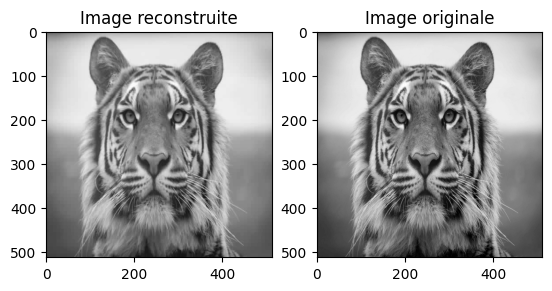

In [26]:
# Reconstruction de l'image à partir de T_chap (on fait l'inverse de ce qu'on a fait plus haut)

T_chap_reconstruit = [bloc*Z for bloc in T_chap_blocs]
T_reconstruit_img = [cv2.idct(np.float32(bloc)) for bloc in T_chap_reconstruit]

img_reconstruit = np.zeros((h, w), np.float32)
for i, bloc in enumerate(T_reconstruit_img):
    x = (i * 8) % w
    y = (i * 8) // w * 8
    img_reconstruit[y:y+8, x:x+8] = bloc

#################### affichage ####################
plt.figure()
plt.subplot(121)
plt.imshow(img_reconstruit, cmap='gray')
plt.title('Image reconstruite')
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title('Image originale')
plt.show()


In [42]:
# codage des valeurs non nulles par plage

def run_length_encoding(X,n_bit):

    if len(X) == 0:
        return []

    maximum = 0
    for i in range(n_bit):
        maximum+=2**i
    # Liste pour stocker les paires (valeur, longueur)
    encoded = []
    
    # Initialisation des variables
    current_value = X[0]
    count = 1

    # si la première valeur est 1, on ajoute un 0 pour le codage
    # if current_value == 0:
    #     encoded.append(0,1)

    # Parcours du vecteur à partir du deuxième élément
    for i in range(1, len(X)):
        if count==maximum:
            encoded.append(count)
            encoded.append(int(current_value))
            current_value = X[i]  # Changer de valeur
            count = 0 
        if X[i] == current_value:
            count += 1  # Si la valeur est identique, on augmente le compteur
        else:
            encoded.append(count)
            encoded.append(int(current_value))
            current_value = X[i]  # Changer de valeur
            count = 1  # Réinitialiser le compteur

    # Ajouter la dernière plage
    encoded.append(count)
    encoded.append(int(current_value))
    
    return encoded

# codage des valeurs non nulles par plage
codage = [run_length_encoding(bloc, 3) for bloc in T_pos_zigzag_blocs]


In [64]:
def run_length_decoding(encoded_bloc, bit_length=3):
    """
    Décodage d'un bloc encodé par run-length encoding.
    Chaque valeur de l'encodage est une plage codée par bit_length bits.
    
    Args:
        encoded_bloc (list[int]): Bloc codé sous forme de liste d'entiers.
        bit_length (int): Nombre de bits utilisés pour coder les plages.
    
    Returns:
        list[int]: Liste décodée contenant les positions d'origine.
    """
    decoded = []
    value = encoded_bloc[0]
    for ind in range(0, len(encoded_bloc), 2):
        num = encoded_bloc[ind]
        value = encoded_bloc[ind+1]
        for i in range(num):
            decoded.append(value)
    return np.array(decoded)


# Reconstruction de T_chap_blocs
T_pos_zigzag_blocs_decode = [run_length_decoding(encoded_bloc, bit_length=3) for encoded_bloc in codage]

# Exemple de vérification
print(np.array_equal(T_pos_zigzag_blocs_decode, T_pos_zigzag_blocs)) 


True


In [69]:
# Decode JPEG

def zigzag_order_decode(val,rows,col):
    # Retourne un tableau 1D contenant les éléments de la matrice en ordre zigzag

    
    result = np.zeros((rows,col))
    ind = 0

    for Sxy in range(col):                   # on parcourt les premières diagonales de la matrice
        if Sxy % 2 != 0:                     # si la diagonale est impaire
            for i in range(Sxy + 1):         # on boucle de 0 au numéro de la diagonale (i augmente)
                j = Sxy - i                  # j diminue pour suivre la diagonale
                result[i][j] = int(val[ind] )
                ind+=1                       # on ajoute l'élément à la liste
        else:                                # si la diagonale est paire
            for j in range(Sxy + 1):         # on boucle j sur le numéro de la diagonale (j augmente)
                i = Sxy - j                  # i diminue pour suivre la diagonale
                result[i][j] = int(val[ind] )
                ind+=1 

    for Sxy in range(col, rows):              # on parcourt les diagonales suivantes
        if Sxy % 2 != 0:
            for i in range(Sxy - col-1, col): # on boucle de la diagonale au nombre total de diagonales 
                j = Sxy - i
                result[i][j] = int(val[ind] )
                ind+=1 
        else:
            for j in range(Sxy - col-1, col):
                i = Sxy - j
                result[i][j] = int(val[ind] )
                ind+=1 
    return result.astype(int)

T_pos_blocs_reco = [zigzag_order_decode(bloc,8,8) for bloc in T_pos_zigzag_blocs_decode]
print(T_pos_blocs_reco[3830])
print(T_pos_blocs[3830])
print(np.array_equal(T_pos_blocs_reco[3880], T_pos_blocs[3880])) 

num=0
for i in range(len(T_pos_blocs)):
    if not np.array_equal(T_pos_blocs_reco[i], T_pos_blocs[i]):
        print(i)
        num+=1

print(num)



[[1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
True
2542
2667
2733
2771
2772
2773
2793
2795
2796
2835
2860
2861
2897
2898
2901
2918
2920
2925
2961
2963
2965
2982
2983
2985
2987
2989
2993
3027
3028
3031
3045
3046
3047
3048
3053
3057
3090
3091
3092
3112
3113
3116
3117
3157
3159
3176
3182
3220
3241
3246
3284
3373
3505
3700
3765
3830
56


In [ ]:
# Calcul de la mémoire avec le codage par plage

# Taille d'un élément de T_pos_zigzag_blocs
taille_T_pos_codage_blocs = 0
for bloc in codage:
    taille_T_pos_codage_blocs += 3*len(bloc)

# Taille totale
taille_totale_codage = taille_T_pos_codage_blocs + taille_T_val_blocs

# Taux de compression
compression_ratio_codage = (h*w*8) / taille_totale_codage

############## affichage ##############
print("Taille totale : ", taille_totale_codage)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio_codage,2))

Taille totale :  278621
Taille initiale :  2097152
Taux de compression :  7.53


In [ ]:
# Optimisation 
# On veut diminuer la valeur maximale de la liste des valeurs non nulles pour diminuer la taille de la liste des positions
# La valeur maximale se situe toujours en premier dans la liste des valeurs non nulles
# En parcourant les blocs, on va prendre pour le premier bloc la valeur de base
# Pour les blocs suivants, on va prendre la valeur de base - la valeur du bloc précédent

T_val_opt = [bloc.copy() for bloc in T_val_blocs]

previous = 0
for i in range(0,len(T_val_opt)):
    new = T_val_opt[i][0] - previous
    previous = T_val_opt[i][0]
    T_val_opt[i][0] = new

# Calcul de la mémoire avec codage par plage et optimisation

# Taille d'un élément de T_val_opt
taille_T_val_opt = 0   

for bloc in T_val_opt:
    min_bits = min_bits_to_code(bloc)
    taille_T_val_opt += min_bits * len(bloc)

# Taille totale
taille_totale_opt = taille_T_pos_codage_blocs + taille_T_val_opt

# Taux de compression
compression_ratio_opt = (h*w*8) / taille_totale_opt

############## affichage ##############
print("Taille totale : ", taille_totale_opt)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio_opt,2))


Taille totale :  225888
Taille initiale :  2097152
Taux de compression :  9.28
